<a href="https://colab.research.google.com/github/Jangalang2911/ML-Ongoing/blob/master/linear-logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Linear Model

In [15]:
#imports
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import urllib

%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [16]:
import tensorflow.feature_column as fc

import tensorflow as tf

In [7]:
#loading the data
df_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
df_eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = df_train.pop('survived')
y_eval = df_eval.pop('survived')

df_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [26]:
#making feature columns
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []

for feature in CATEGORICAL_COLUMNS:
  vocab = df_train[feature].unique()
  feature_columns.append(tf.feature_column.sequence_categorical_column_with_vocabulary_list(feature, vocab))

for feature in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))

print(feature_columns)

[SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(

In [37]:
#Input fn : converting pd dataframe to a tf usable format
def make_input_fn(data_df, label_df,  num_epochs=1000, shuffle=True, batch_size=32):
  def input_fn():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_fn  # returning the fn object


train_input_fn = make_input_fn(df_train, y_train)
eval_input_fn = make_input_fn(df_eval, y_eval, shuffle=False, num_epochs=1)

In [45]:
for feature_batch, label_batch in train_input_fn().take(1):
  print("Some feature keys:" , list(feature_batch.keys()))
  print()
  print("A batch for a class:" , feature_batch['sex'].numpy()) # sex feature for observations
  print()
  print("A label batch:", label_batch.numpy()) #survived or not

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch for a class: [b'male' b'male' b'male' b'male' b'female' b'male' b'male' b'female'
 b'female' b'male' b'male' b'male' b'female' b'male' b'male' b'male'
 b'female' b'male' b'female' b'male' b'female' b'male' b'female' b'male'
 b'female' b'male' b'female' b'male' b'male' b'male' b'male' b'male']

A label batch: [0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0]


In [51]:
#model time baby
linear_model = tf.estimator.LinearClassifier(feature_columns=feature_columns) # passing in the feature_columns created earlier

linear_model.train(train_input_fn)
result = linear_model.evaluate(eval_input_fn)

clear_output()
print(result)


{'accuracy': 0.7689394, 'accuracy_baseline': 0.625, 'auc': 0.83143556, 'auc_precision_recall': 0.7674034, 'average_loss': 0.48000163, 'label/mean': 0.375, 'loss': 0.45717457, 'precision': 0.6938776, 'prediction/mean': 0.39399168, 'recall': 0.68686867, 'global_step': 20000}


<Axes: title={'center': 'Prediction probabilities'}, ylabel='Frequency'>

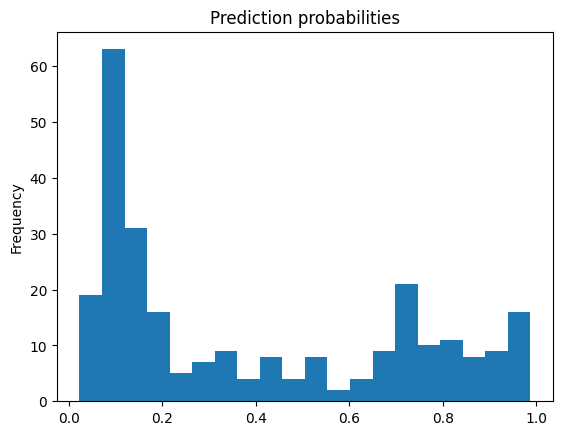

In [55]:
pred_dict = list(linear_model.predict(eval_input_fn)) #generates a dict for each datapoint

probs = pd.Series(pred['probabilities'][1] for pred in pred_dict) # obtaining a list of probabilities for each datapoint
probs.plot(kind='hist', bins=20, title='Prediction probabilities')




---




Logistic Regression/Classification

In [66]:
#loading data
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train_path = tf.keras.utils.get_file( "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file( "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

df_train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0) #header=0 assigns row 0 as name columns
df_test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

In [67]:
df_train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [69]:
y_train = df_train.pop('Species')
y_test = df_test.pop('Species')

In [72]:
#Input fn
def logistic_input_fn(features, labels, training=True, batch_size=256):
  ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))

  if training:
    ds = ds.shuffle(1000).repeat()

  return ds.batch(batch_size)

In [74]:
my_feature_columns = []
for key in df_train.keys():
  my_feature_columns.append(tf.feature_column.numeric_column(key=key, dtype=tf.float32))

print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [76]:
#model
logit_model = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,
                                         hidden_units=[30,10], #2 hidden layers, one with 30 neurons, one with 10
                                         n_classes=3)
logit_model.train(input_fn= lambda: logistic_input_fn(df_train, y_train),
                  steps=5000)

Instructions for updating:
Use tf.keras instead.


In [77]:
eval_result = logit_model.evaluate(input_fn=lambda: logistic_input_fn(df_test, y_test, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.733



In [85]:
#Prediction time baby
def input_fn(x_train, batch_size=256):
  return tf.data.Dataset.from_tensor_slices(dict(x_train)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
user_inputs={}

print("Please type input values as prompted:")
for feature in features:
  valid = True
  while valid:
    value = input(feature + ':')
    if not value.isdigit(): valid = False
  user_inputs[feature] = [float(value)]

predictions = logit_model.predict(input_fn=lambda: input_fn(user_inputs))
for pred_dict in predictions:
  class_id = pred_dict['class_ids'][0]
  probability = pred_dict['probabilities'][0]

print("Prediction is: {} with {0.3f % probability}".format( SPECIES[class_id] ,probability*100))

Please type input values as prompted:
SepalLength:0.5
SepalWidth:0.5
PetalLength:0.5
PetalWidth:0.5
Prediction is: {} with {0.3f % probability} Virginica 0.3269787
